Dependencies

In [1]:
import sys
import os
import json
import numpy as np
import pandas as pd
from importlib import import_module
import seaborn as sns
import matplotlib.pyplot as plt

# Add the parent directory to the Python path
sys.path.append(os.path.abspath('..'))

from rdt.transformers.utils import learn_rounding_digits
from joblib import Parallel, delayed

# Now this will work
from personnal_packages_new.data_load import read_csv
from personnal_packages_new.BaseTrans import BaseTransformer
from personnal_packages_new.NullTrans import NullTransformer
from personnal_packages_new.NumericalTransformer import ClusterBasedNormalizer
from personnal_packages_new.CategoricalTransformer import OneHotEncoder
from personnal_packages_new.data_trans import DataTransformer

In [2]:
data_path = '../rhc.csv'
metadata_path = '../light_metadata.json'

In [3]:
data, discrete_columns = read_csv(data_path, metadata_path, header=True)

Found 35 discrete columns from metadata


Data set: 35 categorical + 27 continuous = 62 columns

In [4]:
Na_columns = data.columns[data.isna().any()].tolist()
print("Na_columns:", Na_columns)

Na_columns: ['cat2', 'dschdte', 'dthdte', 'adld3p', 'urin1']


continius columns extraction

In [5]:
continuous_columns = [col for col in data.columns if col not in discrete_columns]
print(f"Colonnes continues: {continuous_columns}")

Colonnes continues: ['sadmdte', 'dschdte', 'dthdte', 'lstctdte', 'age', 'edu', 'surv2md1', 'das2d3pc', 't3d30', 'aps1', 'scoma1', 'meanbp1', 'wblc1', 'hrt1', 'resp1', 'temp1', 'pafi1', 'alb1', 'hema1', 'bili1', 'crea1', 'sod1', 'pot1', 'paco21', 'ph1', 'wtkilo1', 'urin1']


Analyse data transformation

In [6]:
# Initialize the DataTransformer
dt = DataTransformer(max_clusters=10, weight_threshold=0.005)

In [7]:
# Fit the DataTransformer to the data
dt.fit(data, discrete_columns=discrete_columns)

In [8]:
continuous_transform_info = [info for info in dt._column_transform_info_list 
                           if info.column_type == 'continuous']

for info in continuous_transform_info[:5]:  # Limiter l'affichage aux 5 premières colonnes
    print(f"\nColonne: {info.column_name}")
    print(f"Type: {info.column_type}")
    print(f"Dimensions de sortie: {info.output_dimensions}")
    print(f"Info de sortie: {info.output_info}")
    
    # Accéder aux détails du ClusterBasedNormalizer pour cette colonne
    gm = info.transform
    valid_components = sum(gm.valid_component_indicator)
    print(f"Nombre de composantes valides: {valid_components}")
    


Colonne: sadmdte
Type: continuous
Dimensions de sortie: 11
Info de sortie: [SpanInfo(dim=1, activation_fn='tanh'), SpanInfo(dim=np.int64(10), activation_fn='softmax')]
Nombre de composantes valides: 10

Colonne: dschdte
Type: continuous
Dimensions de sortie: 11
Info de sortie: [SpanInfo(dim=1, activation_fn='tanh'), SpanInfo(dim=np.int64(10), activation_fn='softmax')]
Nombre de composantes valides: 10

Colonne: dthdte
Type: continuous
Dimensions de sortie: 11
Info de sortie: [SpanInfo(dim=1, activation_fn='tanh'), SpanInfo(dim=np.int64(10), activation_fn='softmax')]
Nombre de composantes valides: 10

Colonne: lstctdte
Type: continuous
Dimensions de sortie: 11
Info de sortie: [SpanInfo(dim=1, activation_fn='tanh'), SpanInfo(dim=np.int64(10), activation_fn='softmax')]
Nombre de composantes valides: 10

Colonne: age
Type: continuous
Dimensions de sortie: 11
Info de sortie: [SpanInfo(dim=1, activation_fn='tanh'), SpanInfo(dim=np.int64(10), activation_fn='softmax')]
Nombre de composantes v

In [9]:
transformed_data = dt.transform(data)
print(f"Dimensions des données transformées: {transformed_data.shape}")

Dimensions des données transformées: (5735, 6104)


In [10]:
# Analyse the structure of transformed data

transformed_dims = {}
start_idx = 0

for info in dt._column_transform_info_list:
    col_name = info.column_name
    dim = info.output_dimensions
    transformed_dims[col_name] = {
        'type': info.column_type,
        'start_idx': start_idx,
        'end_idx': start_idx + dim,
        'dimensions': dim
    }
    start_idx += dim

# Compter les dimensions totales pour les colonnes continues et discrètes
total_continuous_dims = sum(info['dimensions'] for col, info in transformed_dims.items() 
                          if info['type'] == 'continuous')
total_discrete_dims = sum(info['dimensions'] for col, info in transformed_dims.items() 
                        if info['type'] == 'discrete')

print(f"Dimensions totales des colonnes continues transformées: {total_continuous_dims}")
print(f"Dimensions totales des colonnes discrètes transformées: {total_discrete_dims}")


Dimensions totales des colonnes continues transformées: 274
Dimensions totales des colonnes discrètes transformées: 5830


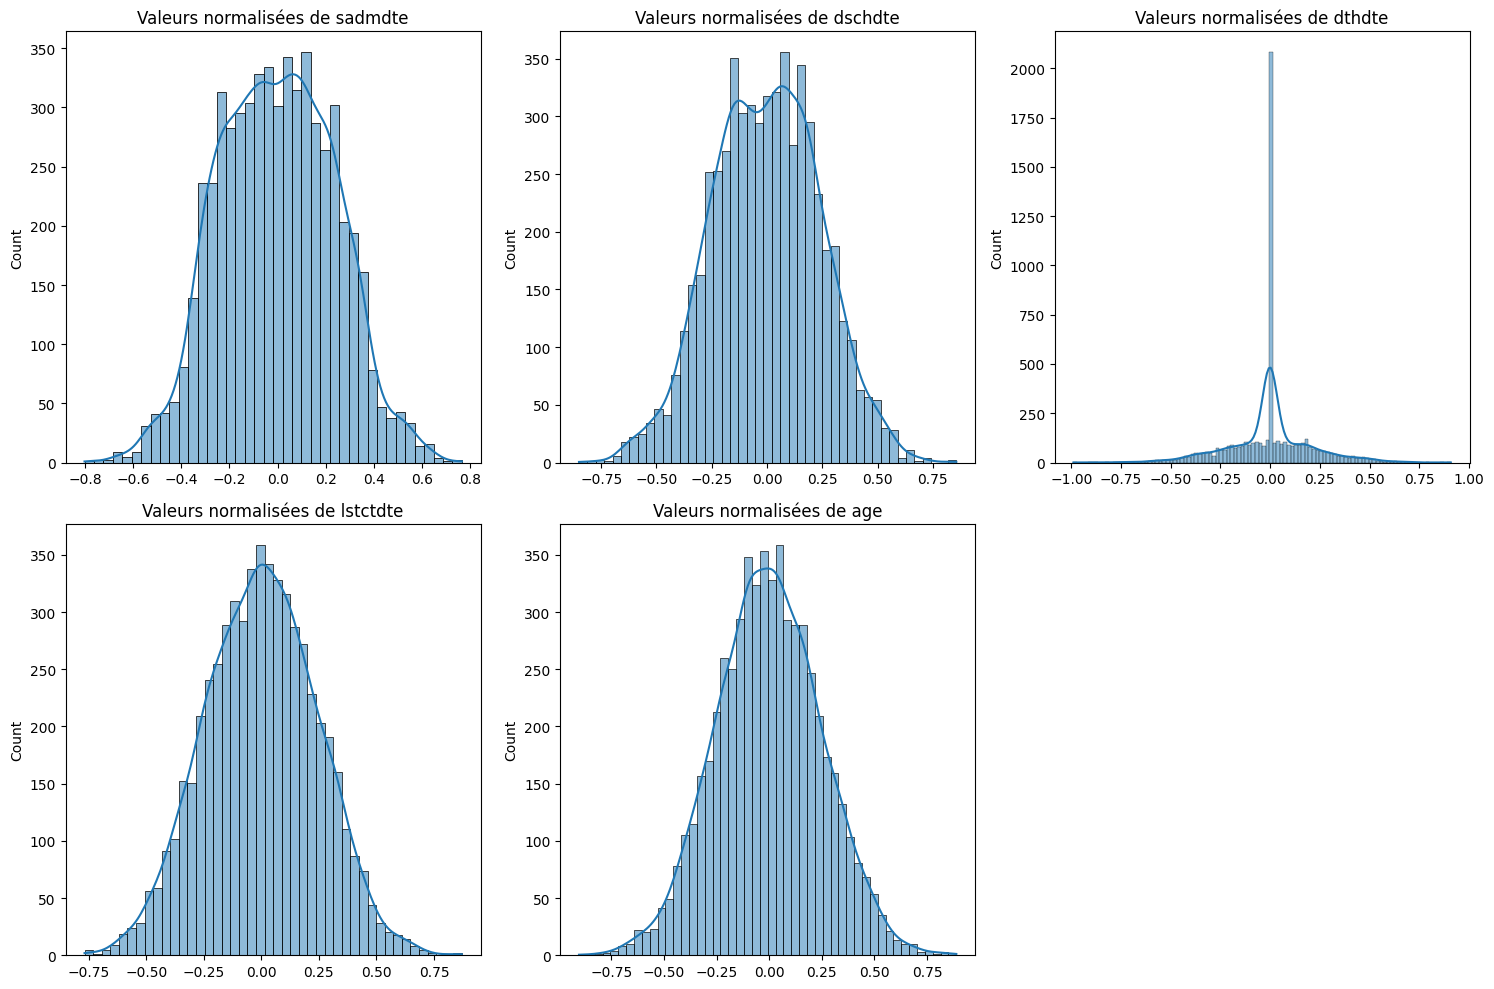

In [11]:
# Visualiser la distribution des premières colonnes continues transformées
plt.figure(figsize=(15, 10))
continuous_cols_info = [(col, info) for col, info in transformed_dims.items() 
                      if info['type'] == 'continuous']

for i, (col, info) in enumerate(continuous_cols_info[:5]):  # Limiter à 5 pour la clarté
    plt.subplot(2, 3, i+1)
    # Afficher la valeur normalisée (première dimension)
    normalized_values = transformed_data[:, info['start_idx']]
    sns.histplot(normalized_values, kde=True)
    plt.title(f'Valeurs normalisées de {col}')
plt.tight_layout()
plt.show()

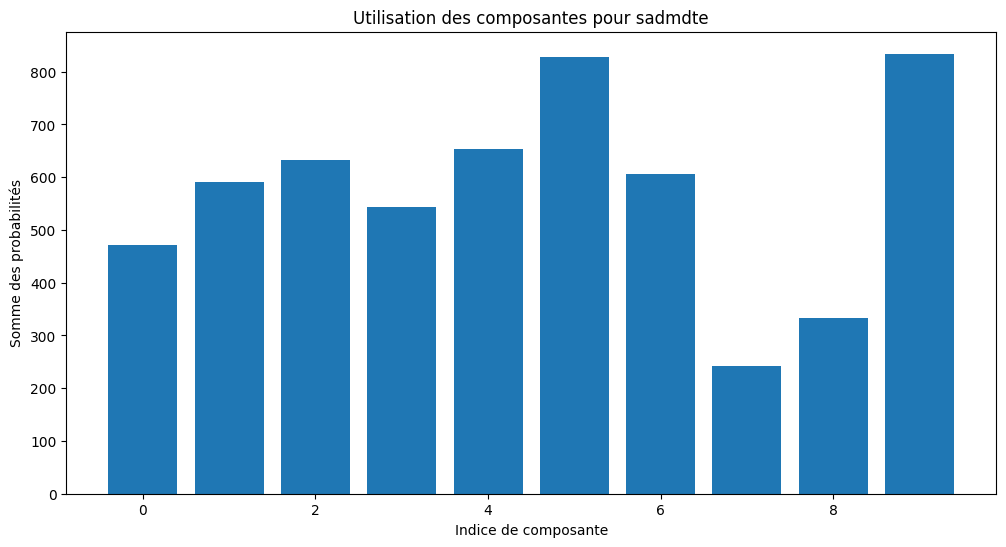

In [12]:
# Visualiser la distribution des composantes pour une colonne continue
if continuous_cols_info:
    col, info = continuous_cols_info[0]  # Prendre la première colonne continue
    plt.figure(figsize=(12, 6))
    
    # Récupérer les indices des colonnes pour les composantes
    component_start = info['start_idx'] + 1
    component_end = info['end_idx']
    
    # Somme des probabilités pour chaque composante
    component_sums = transformed_data[:, component_start:component_end].sum(axis=0)
    
    # Créer un barplot
    plt.bar(range(len(component_sums)), component_sums)
    plt.title(f'Utilisation des composantes pour {col}')
    plt.xlabel('Indice de composante')
    plt.ylabel('Somme des probabilités')
    plt.show()

Data original v/s data inverse trans

In [16]:
# Add this cell to your notebook

# Let's examine the first continuous column transformation
col, info = continuous_cols_info[0]
print(f"Column: {col}")

# Look at the structure of the transformed data for this column
start_idx = info['start_idx']
end_idx = info['end_idx']
print(f"Start: {start_idx}, End: {end_idx}, Dimensions: {end_idx - start_idx}")

# Get the transformer
gm = dt._column_transform_info_list[0].transform
print(f"Output sdtypes: {gm.get_output_sdtypes()}")

# Check the shape of the column's transformed data
col_data = transformed_data[:, start_idx:end_idx]
print(f"Column transformed data shape: {col_data.shape}")

# Show a small sample of the transformed data
print("First 3 rows of transformed data:")
print(col_data[:3])

Column: sadmdte
Start: 19, End: 30, Dimensions: 11
Output sdtypes: {'cat1.value0': 'float', 'cat1.value1': 'float', 'cat1.value2': 'float', 'cat1.value3': 'float', 'cat1.value4': 'float', 'cat1.value5': 'float', 'cat1.value6': 'float', 'cat1.value7': 'float', 'cat1.value8': 'float'}
Column transformed data shape: (5735, 11)
First 3 rows of transformed data:
[[-0.07250061  0.          0.          0.          0.          0.
   0.          1.          0.          0.          0.        ]
 [ 0.06467556  0.          0.          1.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.04608333  1.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]]


In [19]:

print("Nombre de colonnes transform_info:", len(dt._column_transform_info_list))
total_dim = 0
for info in dt._column_transform_info_list:
    print(f"Colonne: {info.column_name}, Type: {info.column_type}, Dimensions: {info.output_dimensions}")
    total_dim += info.output_dimensions
print(f"Dimensions totales attendues: {total_dim}")

Nombre de colonnes transform_info: 62
Colonne: cat1, Type: discrete, Dimensions: 9
Colonne: cat2, Type: discrete, Dimensions: 7
Colonne: ca, Type: discrete, Dimensions: 3
Colonne: sadmdte, Type: continuous, Dimensions: 11
Colonne: dschdte, Type: continuous, Dimensions: 11
Colonne: dthdte, Type: continuous, Dimensions: 11
Colonne: lstctdte, Type: continuous, Dimensions: 11
Colonne: death, Type: discrete, Dimensions: 2
Colonne: cardiohx, Type: discrete, Dimensions: 2
Colonne: chfhx, Type: discrete, Dimensions: 2
Colonne: dementhx, Type: discrete, Dimensions: 2
Colonne: psychhx, Type: discrete, Dimensions: 2
Colonne: chrpulhx, Type: discrete, Dimensions: 2
Colonne: renalhx, Type: discrete, Dimensions: 2
Colonne: liverhx, Type: discrete, Dimensions: 2
Colonne: gibledhx, Type: discrete, Dimensions: 2
Colonne: malighx, Type: discrete, Dimensions: 2
Colonne: immunhx, Type: discrete, Dimensions: 2
Colonne: transhx, Type: discrete, Dimensions: 2
Colonne: amihx, Type: discrete, Dimensions: 2
Col

In [21]:
# Ensuite appelez inverse_transform
try:
    reconstructed_data = dt.inverse_transform(transformed_data)
    print(f"Dimensions des données reconstruites: {reconstructed_data.shape}")
except Exception as e:
    print(f"Erreur: {e}")
    
    # Si l'erreur se produit dans _inverse_transform_continuous, voyons les détails
    if "column" in str(e).lower():
        for info in dt._column_transform_info_list:
            if info.column_type == 'continuous':
                transform = info.transform
                print(f"Colonnes disponibles dans le transformateur: {list(transform.get_output_sdtypes())}")

Debug - Input data shape: (5735, 6104)
Debug - Expected columns from metadata: 62
Erreur: Shape of passed values is (5735, 2), indices imply (5735, 3)


In [22]:
# Ajoutez ceci juste avant l'appel à inverse_transform
print("Transformed data shape:", transformed_data.shape)

# Obtenons des informations sur la structure attendue
st = 0
for i, column_transform_info in enumerate(dt._column_transform_info_list):
    dim = column_transform_info.output_dimensions
    print(f"Column {i}: {column_transform_info.column_name}, Type: {column_transform_info.column_type}, Dimensions: {dim}")
    
    if column_transform_info.column_type == 'continuous':
        transform = column_transform_info.transform
        print(f"  Output sdtypes: {transform.get_output_sdtypes()}")
        print(f"  Number of output columns: {len(list(transform.get_output_sdtypes()))}")
    
    st += dim

Transformed data shape: (5735, 6104)
Column 0: cat1, Type: discrete, Dimensions: 9
Column 1: cat2, Type: discrete, Dimensions: 7
Column 2: ca, Type: discrete, Dimensions: 3
Column 3: sadmdte, Type: continuous, Dimensions: 11
  Output sdtypes: {'sadmdte.normalized': 'float', 'sadmdte.component': 'categorical'}
  Number of output columns: 2
Column 4: dschdte, Type: continuous, Dimensions: 11
  Output sdtypes: {'dschdte.normalized': 'float', 'dschdte.component': 'categorical', 'dschdte.is_null': 'float'}
  Number of output columns: 3
Column 5: dthdte, Type: continuous, Dimensions: 11
  Output sdtypes: {'dthdte.normalized': 'float', 'dthdte.component': 'categorical', 'dthdte.is_null': 'float'}
  Number of output columns: 3
Column 6: lstctdte, Type: continuous, Dimensions: 11
  Output sdtypes: {'lstctdte.normalized': 'float', 'lstctdte.component': 'categorical'}
  Number of output columns: 2
Column 7: death, Type: discrete, Dimensions: 2
Column 8: cardiohx, Type: discrete, Dimensions: 2
Col

In [ ]:
# Sauvegardez l'ancienne fonction
import types


original_inverse_transform_continuous = dt._inverse_transform_continuous

# Définissez une fonction modifiée
def fixed_inverse_transform_continuous(self, column_transform_info, column_data, sigmas, st):
    """Fixed version of _inverse_transform_continuous that handles missing or incorrect output_sdtypes.
    
    This method safely handles cases where gm.get_output_sdtypes() doesn't return expected columns
    by using fallback column names when necessary.
    """
    gm = column_transform_info.transform
    
    # Try to get column names safely
    try:
        output_columns = list(gm.get_output_sdtypes())
        if len(output_columns) >= 2:
            # Use available columns
            data = pd.DataFrame(column_data[:, :2], columns=output_columns[:2]).astype(float)
        else:
            # Generate generic names
            column_name = column_transform_info.column_name
            data = pd.DataFrame(column_data[:, :2], columns=[f'{column_name}.normalized', f'{column_name}.component']).astype(float)
    except Exception as e:
        # Fallback to generic names if anything goes wrong
        column_name = column_transform_info.column_name
        data = pd.DataFrame(column_data[:, :2], columns=[f'{column_name}.normalized', f'{column_name}.component']).astype(float)
    
    # Continue with original code
    data[data.columns[1]] = np.argmax(column_data[:, 1:], axis=1)
    if sigmas is not None:
        selected_normalized_value = np.random.normal(data.iloc[:, 0], sigmas[st])
        data.iloc[:, 0] = selected_normalized_value

    return gm.reverse_transform(data)

# Apply the fixed method to your DataTransformer instance
dt._inverse_transform_continuous = types.MethodType(fixed_inverse_transform_continuous, dt)

# Essayez maintenant l'inverse transformation
try:
    reconstructed_data = dt.inverse_transform(transformed_data)
    print(f"Dimensions des données reconstruites: {reconstructed_data.shape}")
except Exception as e:
    print(f"Erreur après tentative de correction: {e}")

# Restaurez la fonction originale si nécessaire
dt._inverse_transform_continuous = original_inverse_transform_continuous

Debug - Input data shape: (5735, 6104)
Debug - Expected columns from metadata: 62
Column name: sadmdte
Column data shape: (5735, 11)
Output sdtypes keys: {'sadmdte.normalized': 'float', 'sadmdte.component': 'categorical'}
Column names from sdtypes: ['sadmdte.normalized', 'sadmdte.component']
Column name: dschdte
Column data shape: (5735, 11)
Output sdtypes keys: {'dschdte.normalized': 'float', 'dschdte.component': 'categorical', 'dschdte.is_null': 'float'}
Column names from sdtypes: ['dschdte.normalized', 'dschdte.component', 'dschdte.is_null']
Attention: Le nombre de colonnes attendu (3) ne correspond pas aux données (11)
Column name: dthdte
Column data shape: (5735, 11)
Output sdtypes keys: {'dthdte.normalized': 'float', 'dthdte.component': 'categorical', 'dthdte.is_null': 'float'}
Column names from sdtypes: ['dthdte.normalized', 'dthdte.component', 'dthdte.is_null']
Attention: Le nombre de colonnes attendu (3) ne correspond pas aux données (11)
Column name: lstctdte
Column data shap